In [238]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install pmdarima
import math
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import seaborn as sns

import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [239]:
#Get the stock quote
google = web.DataReader('GOOG', data_source='yahoo', start = '2012-01-01', end = '2022-03-10')
#show the data 
google.head

<bound method NDFrame.head of                    High          Low         Open        Close      Volume  \
Date                                                                         
2012-01-03   332.827484   324.966949   325.250885   331.462585   7380561.0   
2012-01-04   333.873566   329.076538   331.273315   332.892242   5749470.0   
2012-01-05   330.745270   326.889740   329.828735   328.274536   6590410.0   
2012-01-06   328.767700   323.681763   328.344299   323.796326   5405987.0   
2012-01-09   322.291962   309.455078   322.042908   310.067780  11688849.0   
...                 ...          ...          ...          ...         ...   
2022-03-04  2683.979980  2608.169922  2667.649902  2642.439941   1222300.0   
2022-03-07  2638.080078  2528.199951  2638.080078  2529.290039   1958900.0   
2022-03-08  2624.929932  2517.215088  2525.010010  2545.570068   1762500.0   
2022-03-09  2683.969971  2601.760010  2628.000000  2677.320068   1612900.0   
2022-03-10  2670.770020  2628.0200

In [240]:
date_ori = pd.to_datetime(google.iloc[:, 0]).tolist()
google.head

<bound method NDFrame.head of                    High          Low         Open        Close      Volume  \
Date                                                                         
2012-01-03   332.827484   324.966949   325.250885   331.462585   7380561.0   
2012-01-04   333.873566   329.076538   331.273315   332.892242   5749470.0   
2012-01-05   330.745270   326.889740   329.828735   328.274536   6590410.0   
2012-01-06   328.767700   323.681763   328.344299   323.796326   5405987.0   
2012-01-09   322.291962   309.455078   322.042908   310.067780  11688849.0   
...                 ...          ...          ...          ...         ...   
2022-03-04  2683.979980  2608.169922  2667.649902  2642.439941   1222300.0   
2022-03-07  2638.080078  2528.199951  2638.080078  2529.290039   1958900.0   
2022-03-08  2624.929932  2517.215088  2525.010010  2545.570068   1762500.0   
2022-03-09  2683.969971  2601.760010  2628.000000  2677.320068   1612900.0   
2022-03-10  2670.770020  2628.0200

In [241]:
google.shape

(2564, 6)

<function matplotlib.pyplot.show>

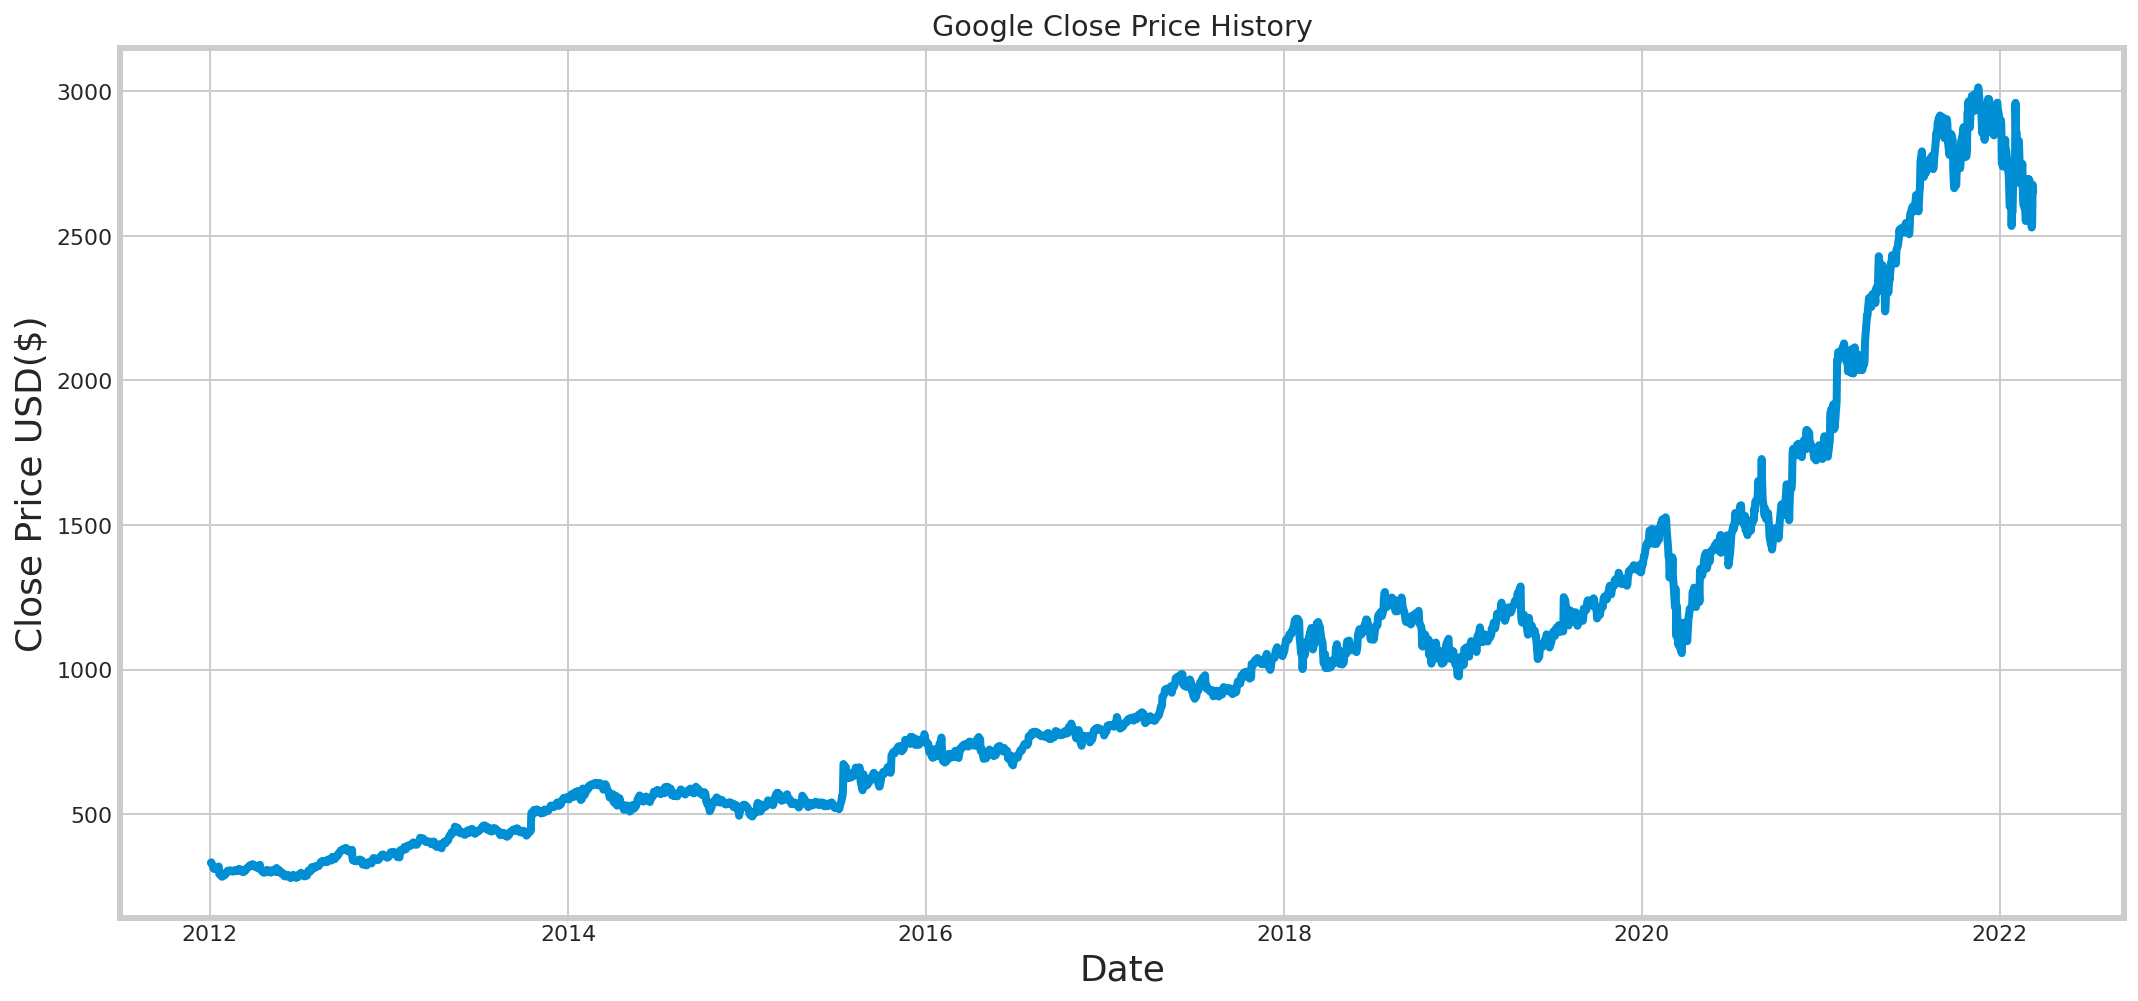

In [242]:
#visualize the closing price history
plt.figure(figsize = (16,8))
plt.title('Google Close Price History')
plt.plot(google['Close'])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price USD($)',fontsize = 18)
plt.show  

In [243]:
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2564 entries, 2012-01-03 to 2022-03-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2564 non-null   float64
 1   Low        2564 non-null   float64
 2   Open       2564 non-null   float64
 3   Close      2564 non-null   float64
 4   Volume     2564 non-null   float64
 5   Adj Close  2564 non-null   float64
dtypes: float64(6)
memory usage: 140.2 KB


In [244]:
#Check for missing values
google.isnull().sum()/len(google)

High         0.0
Low          0.0
Open         0.0
Close        0.0
Volume       0.0
Adj Close    0.0
dtype: float64

In [245]:
null_google=google[pd.isnull(google).any(axis=1)]
null_google

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,


In [247]:
google=google.dropna()

In [246]:
google

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,332.827484,324.966949,325.250885,331.462585,7380561.0,331.462585
2012-01-04,333.873566,329.076538,331.273315,332.892242,5749470.0,332.892242
2012-01-05,330.745270,326.889740,329.828735,328.274536,6590410.0,328.274536
2012-01-06,328.767700,323.681763,328.344299,323.796326,5405987.0,323.796326
2012-01-09,322.291962,309.455078,322.042908,310.067780,11688849.0,310.067780
...,...,...,...,...,...,...
2022-03-04,2683.979980,2608.169922,2667.649902,2642.439941,1222300.0,2642.439941
2022-03-07,2638.080078,2528.199951,2638.080078,2529.290039,1958900.0,2529.290039
2022-03-08,2624.929932,2517.215088,2525.010010,2545.570068,1762500.0,2545.570068


<Figure size 1440x720 with 0 Axes>

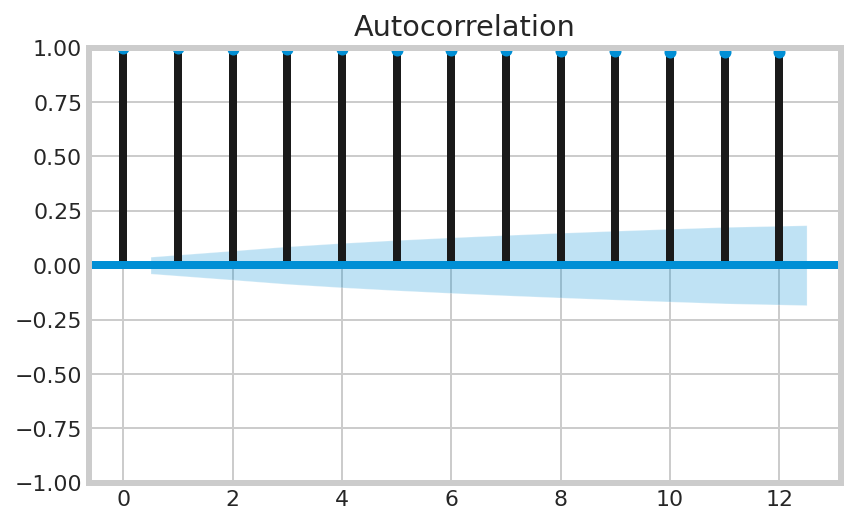

In [248]:
from statsmodels.graphics.tsaplots import plot_acf
google_adj_close=google['Adj Close']
google_close=google['Close']
plt.figure(figsize=(20,10))
plot_acf(google_close,lags=12)
plt.show()

<Figure size 1440x720 with 0 Axes>

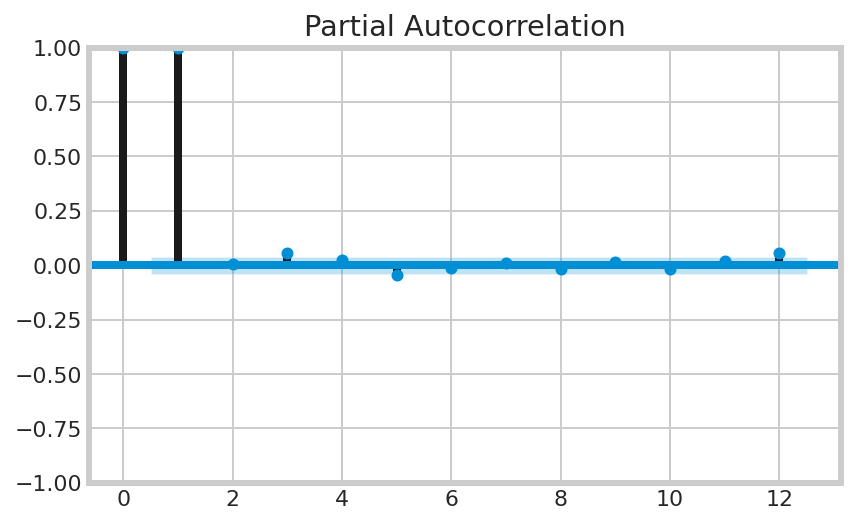

In [249]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,10))
plot_pacf(google_adj_close,lags=12)
plt.show()

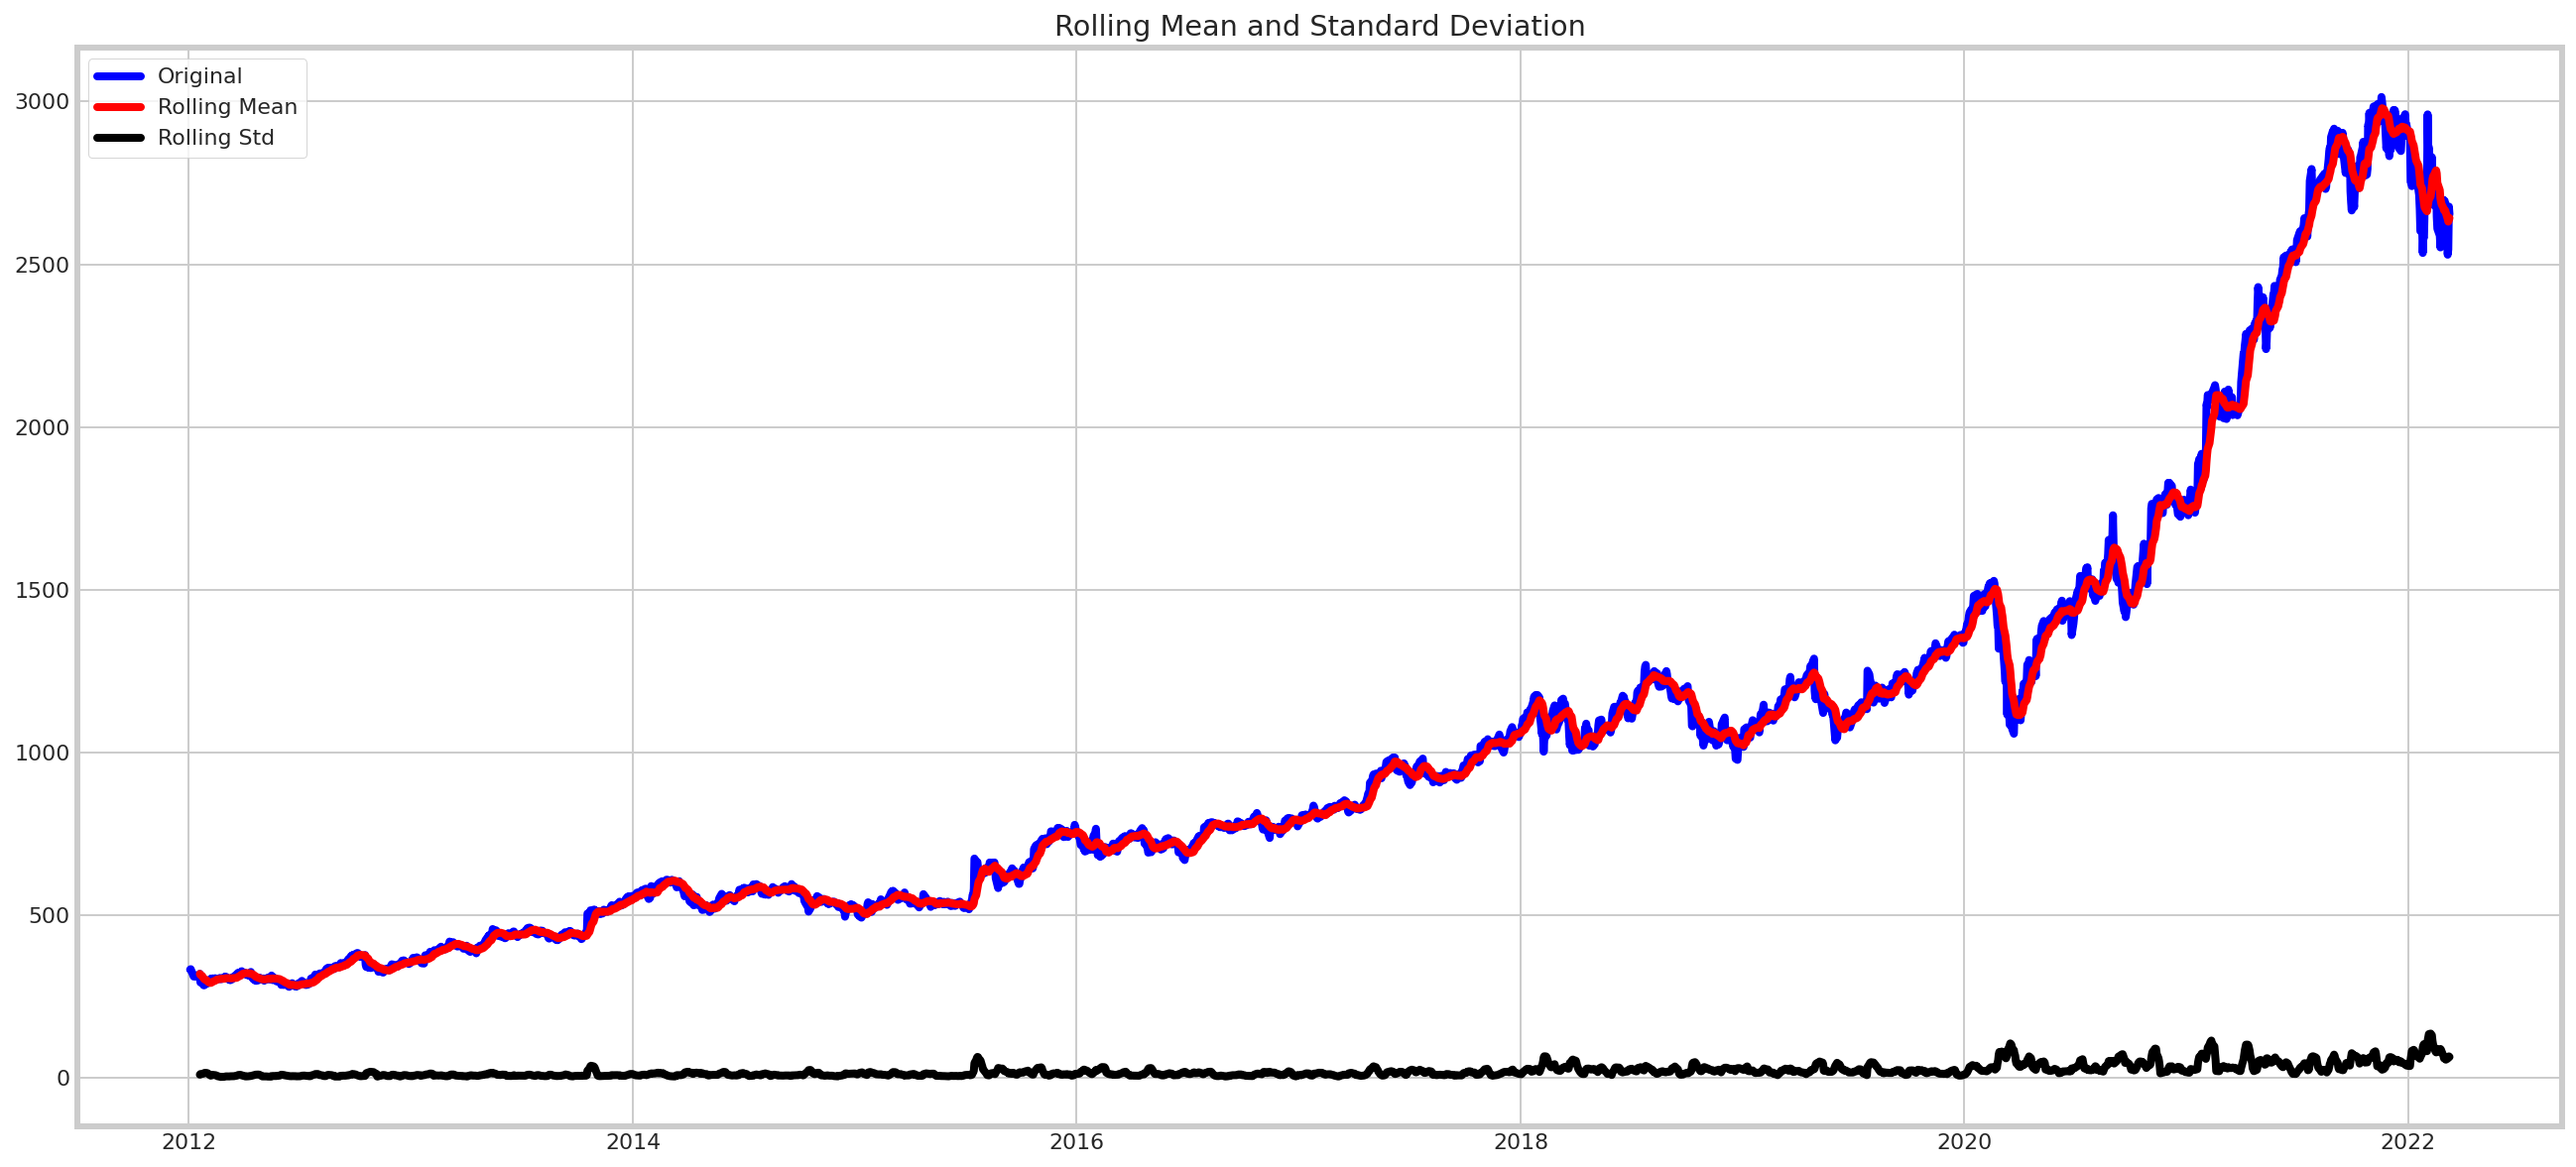

Results of dickey fuller test
Test Statistics                   1.533057
p-value                           0.997642
No. of lags used                 23.000000
Number of observations used    2540.000000
Critical value (1%)              -3.432927
Critical value (5%)              -2.862679
Critical value (10%)             -2.567376
dtype: float64


In [250]:
#Check if the Data is stationary or not,So we perform Augmented-Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
def test_adf(timeseries):
  moving_average=timeseries.rolling(12).mean()
  moving_std=timeseries.rolling(12).std()
  plt.figure(figsize=(20,10))
  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(moving_average, color='red', label='Rolling Mean')
  plt.plot(moving_std, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  print("Results of dickey fuller test")
  adft=adfuller(timeseries,autolag='AIC')
  output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,value in adft[4].items():
    output['Critical value (%s)'%key]=value
  print(output)  


test_adf(google['Adj Close'])

<Figure size 432x288 with 0 Axes>

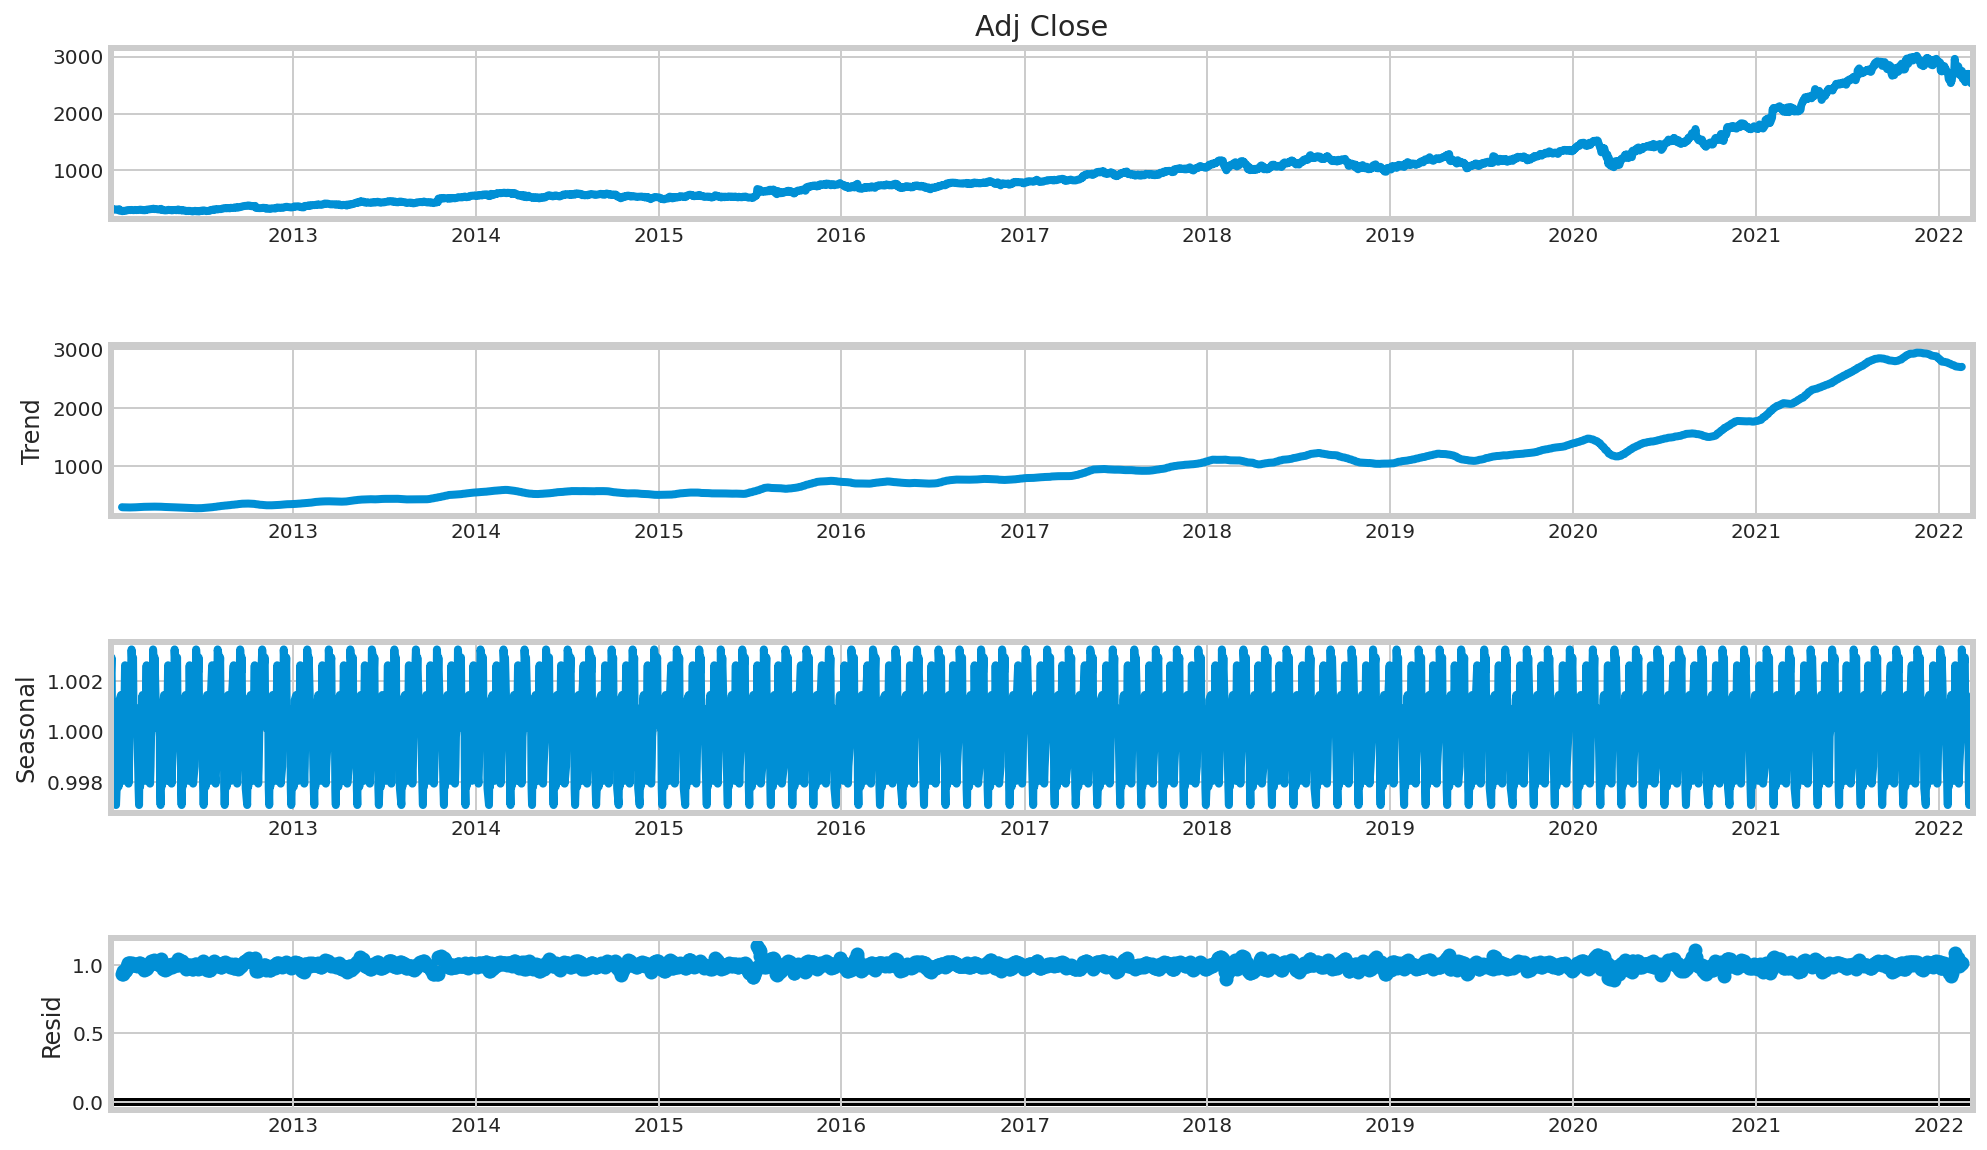

In [122]:
# So p>0.05,so we fail to reject null hypothesis,and test statistics is greater than critical values meaning Data is not stationary
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(google_adj_close,model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16,9)

No handles with labels found to put in legend.


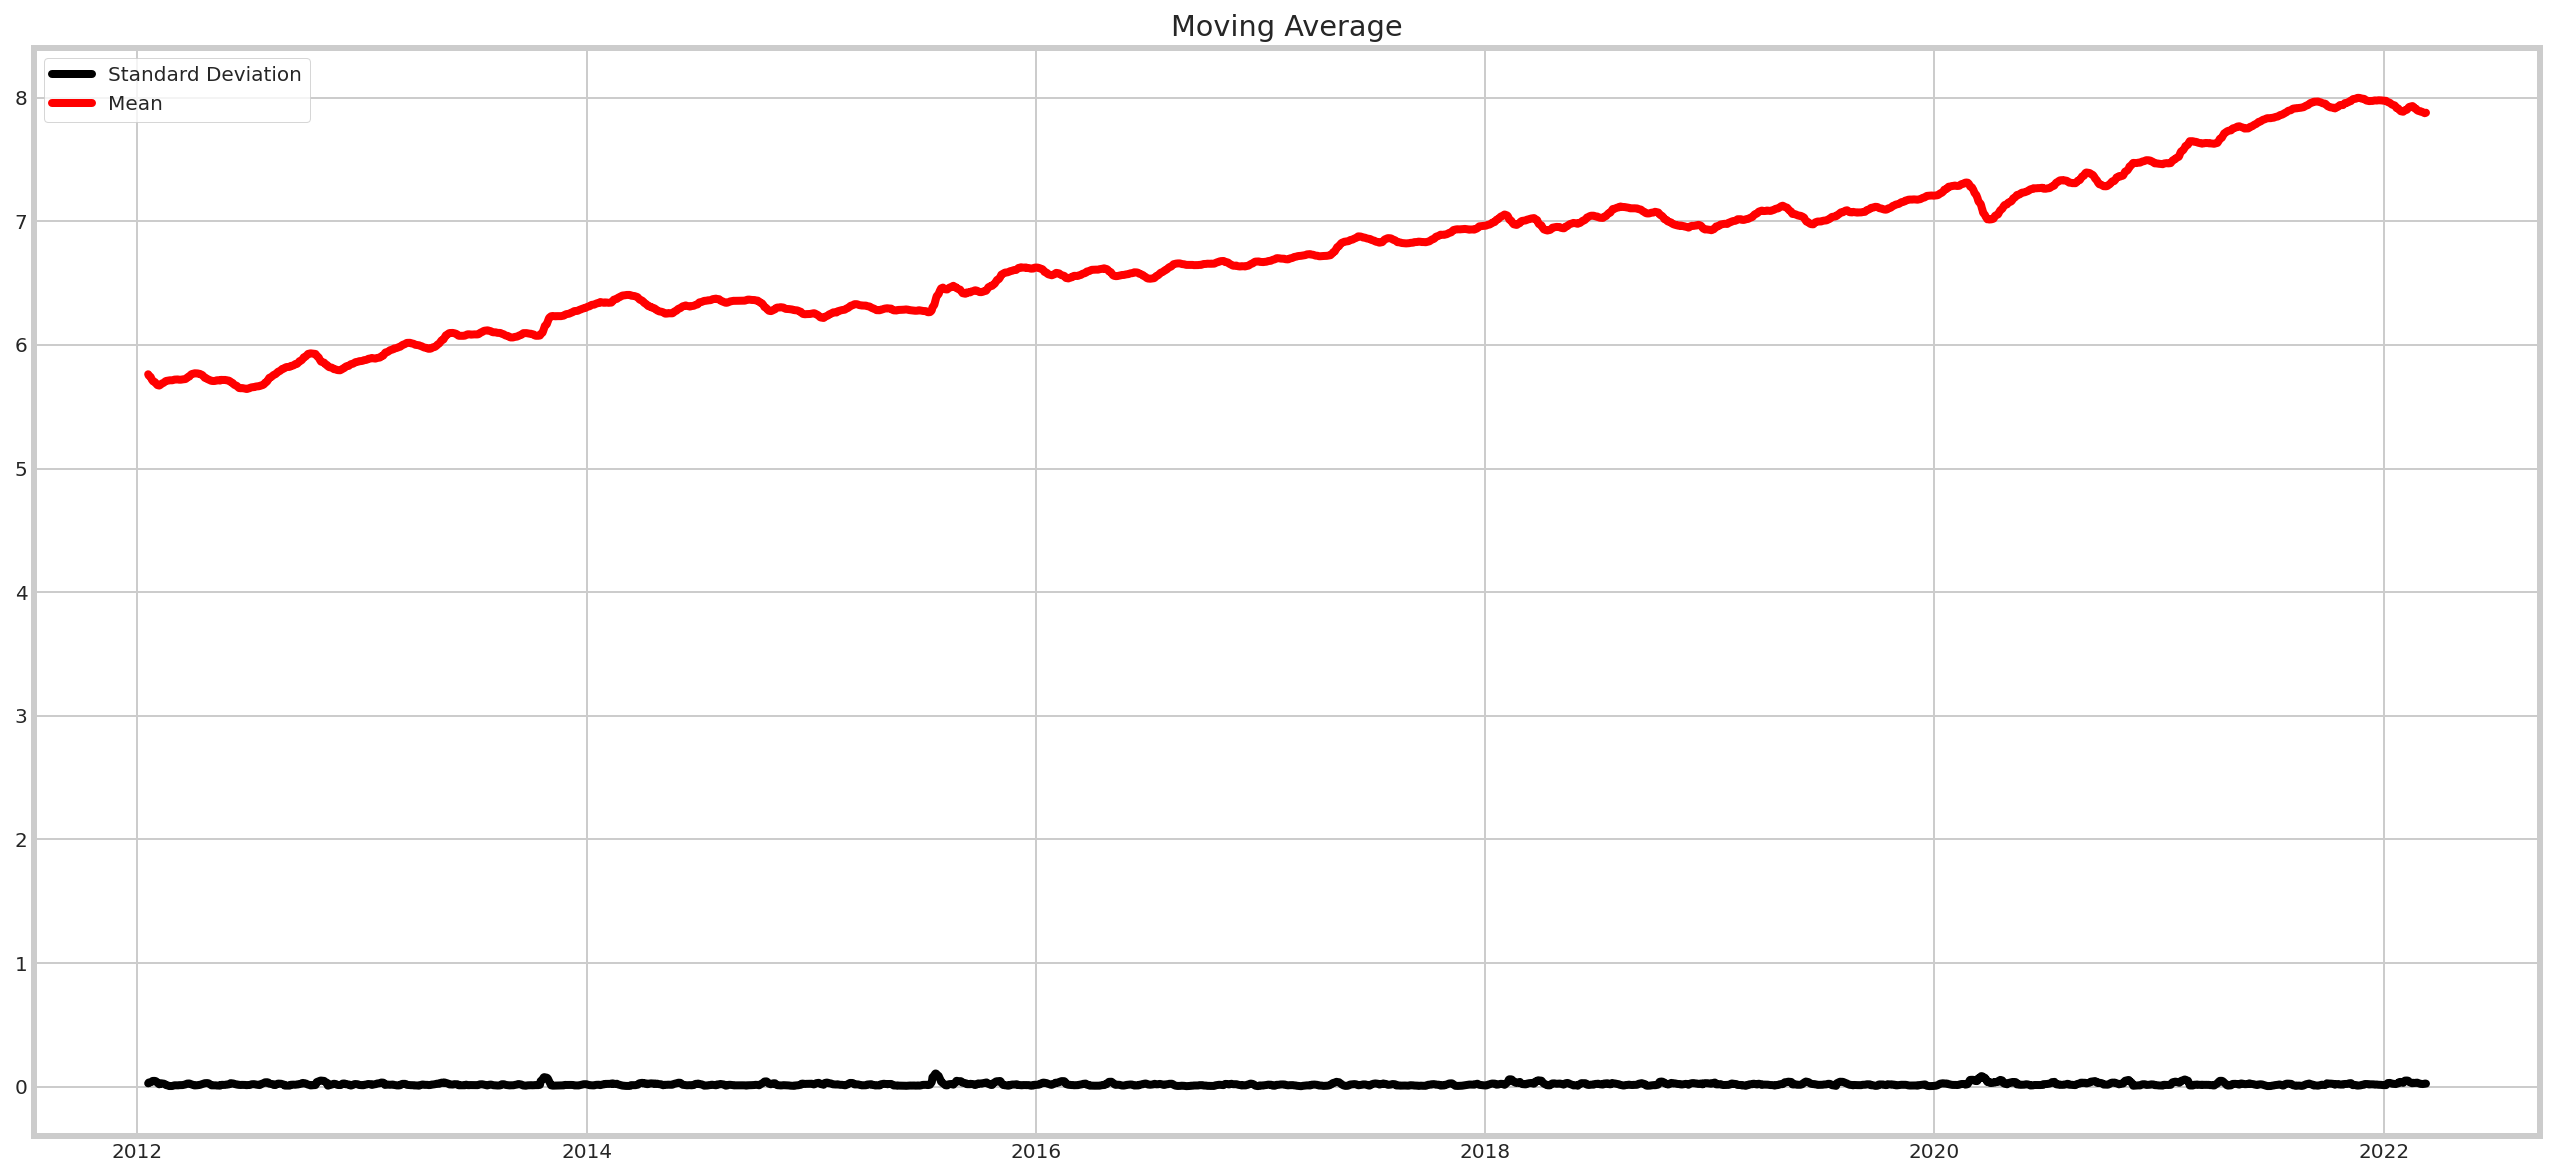

In [123]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
google_adj_close_log=np.log(google_adj_close)
moving_average=google_adj_close_log.rolling(12).mean()
std_dev=google_adj_close_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_average, color="red", label = "Mean")
plt.legend()
plt.show()

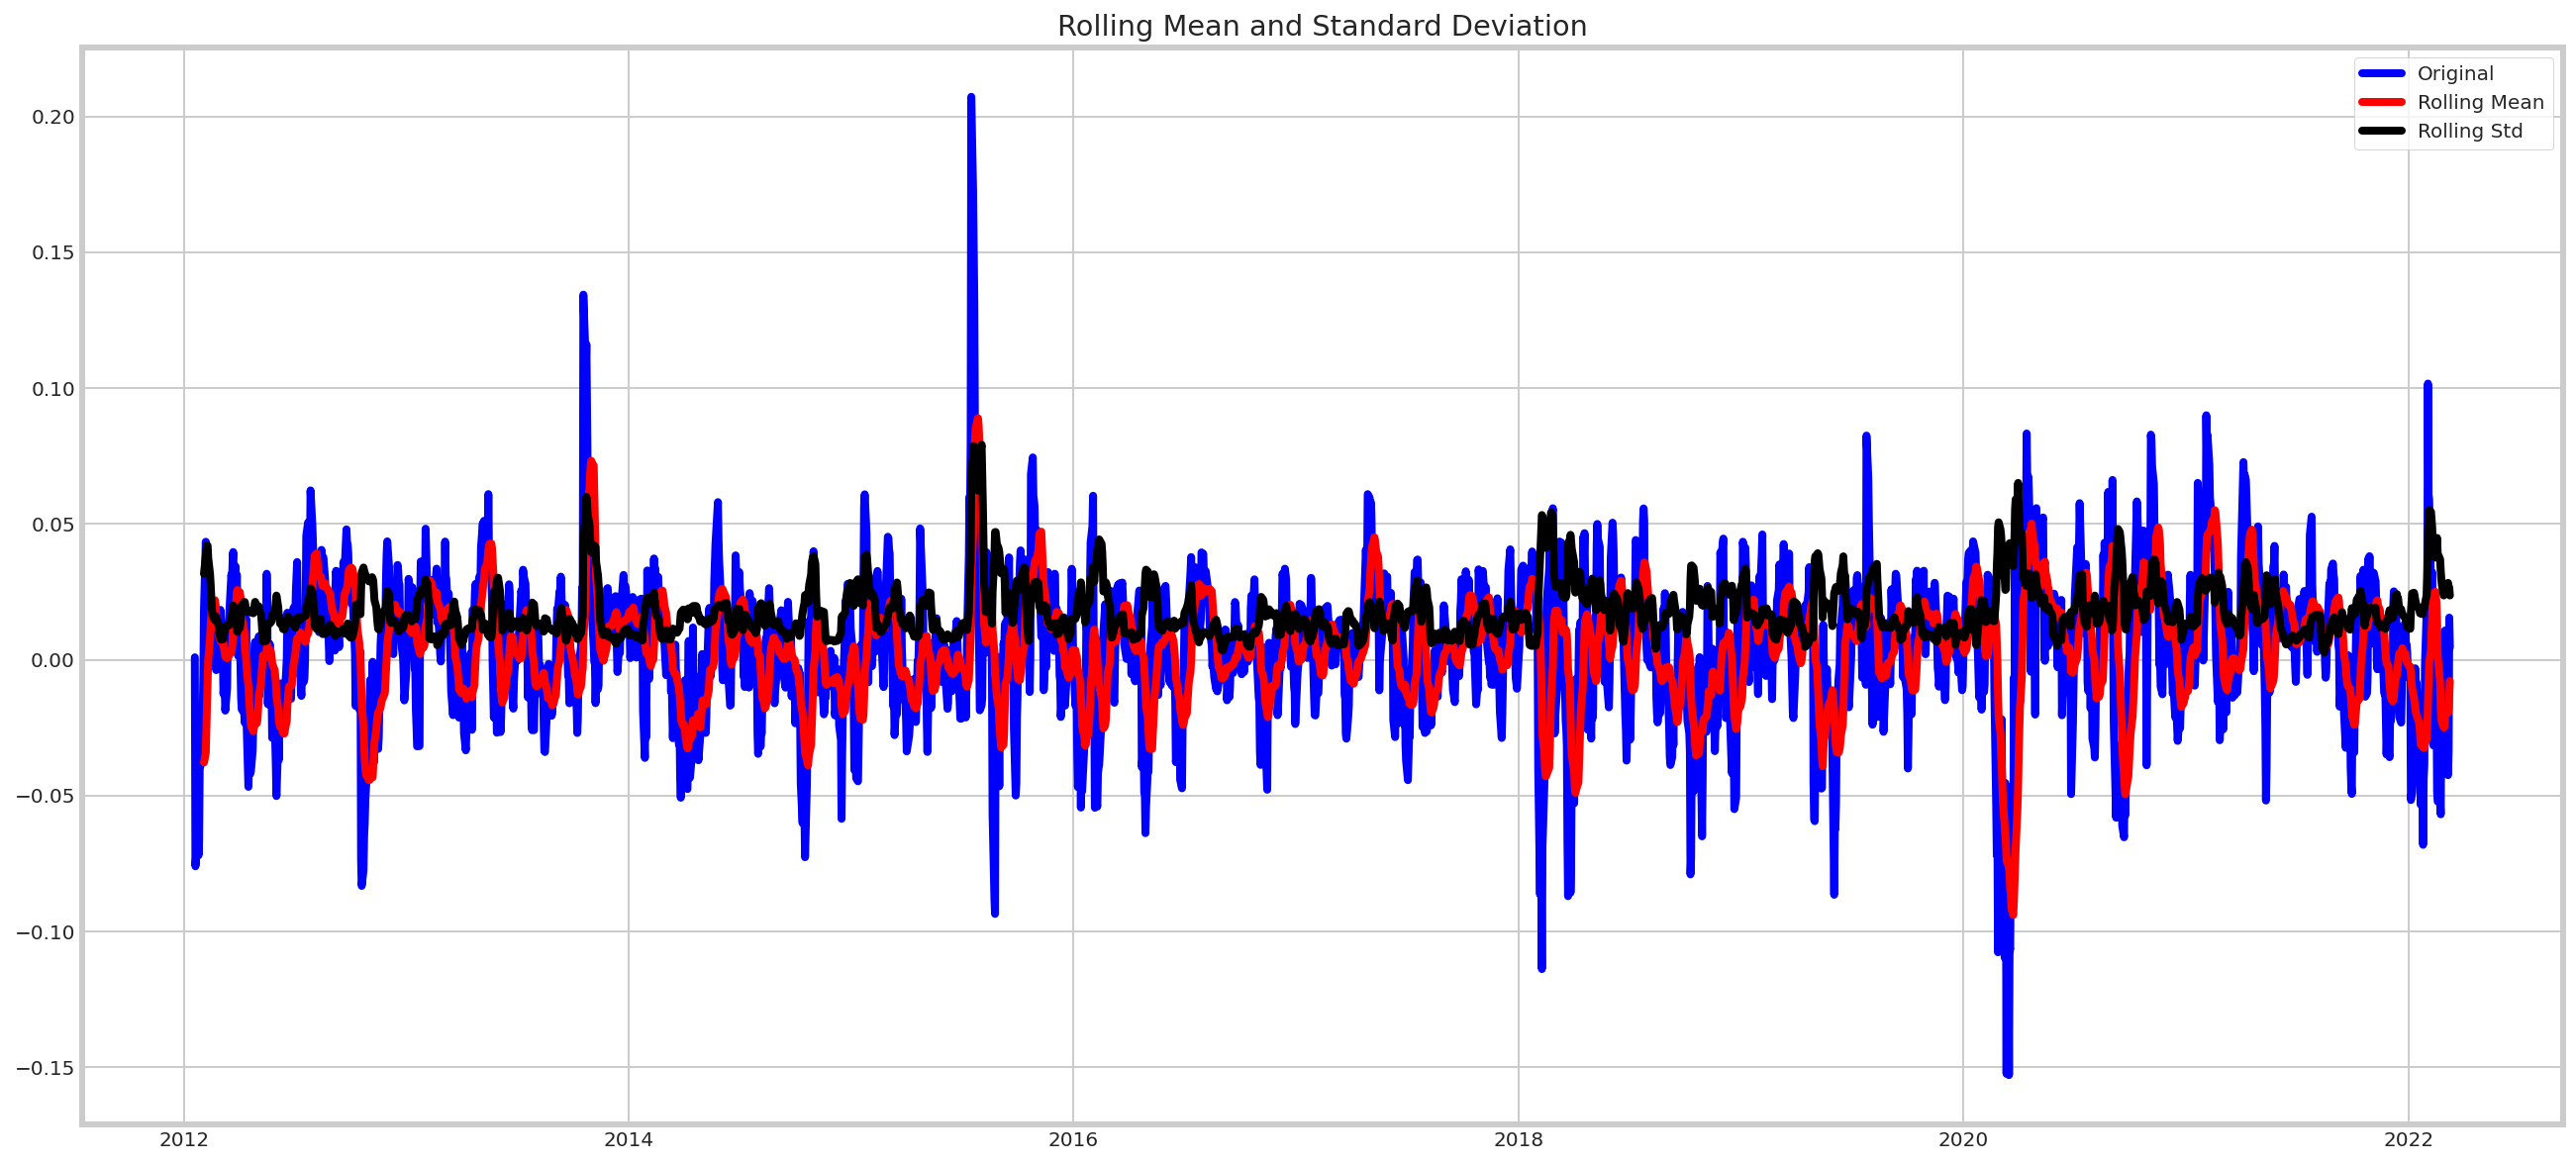

Results of dickey fuller test
Test Statistics               -1.101885e+01
p-value                        6.059120e-20
No. of lags used               1.800000e+01
Number of observations used    2.534000e+03
Critical value (1%)           -3.432933e+00
Critical value (5%)           -2.862681e+00
Critical value (10%)          -2.567378e+00
dtype: float64


In [124]:
google_log_minus_mean = google_adj_close_log - moving_average   #One technique to make time series Stationary
google_log_minus_mean.dropna(inplace=True)
test_adf(google_log_minus_mean)

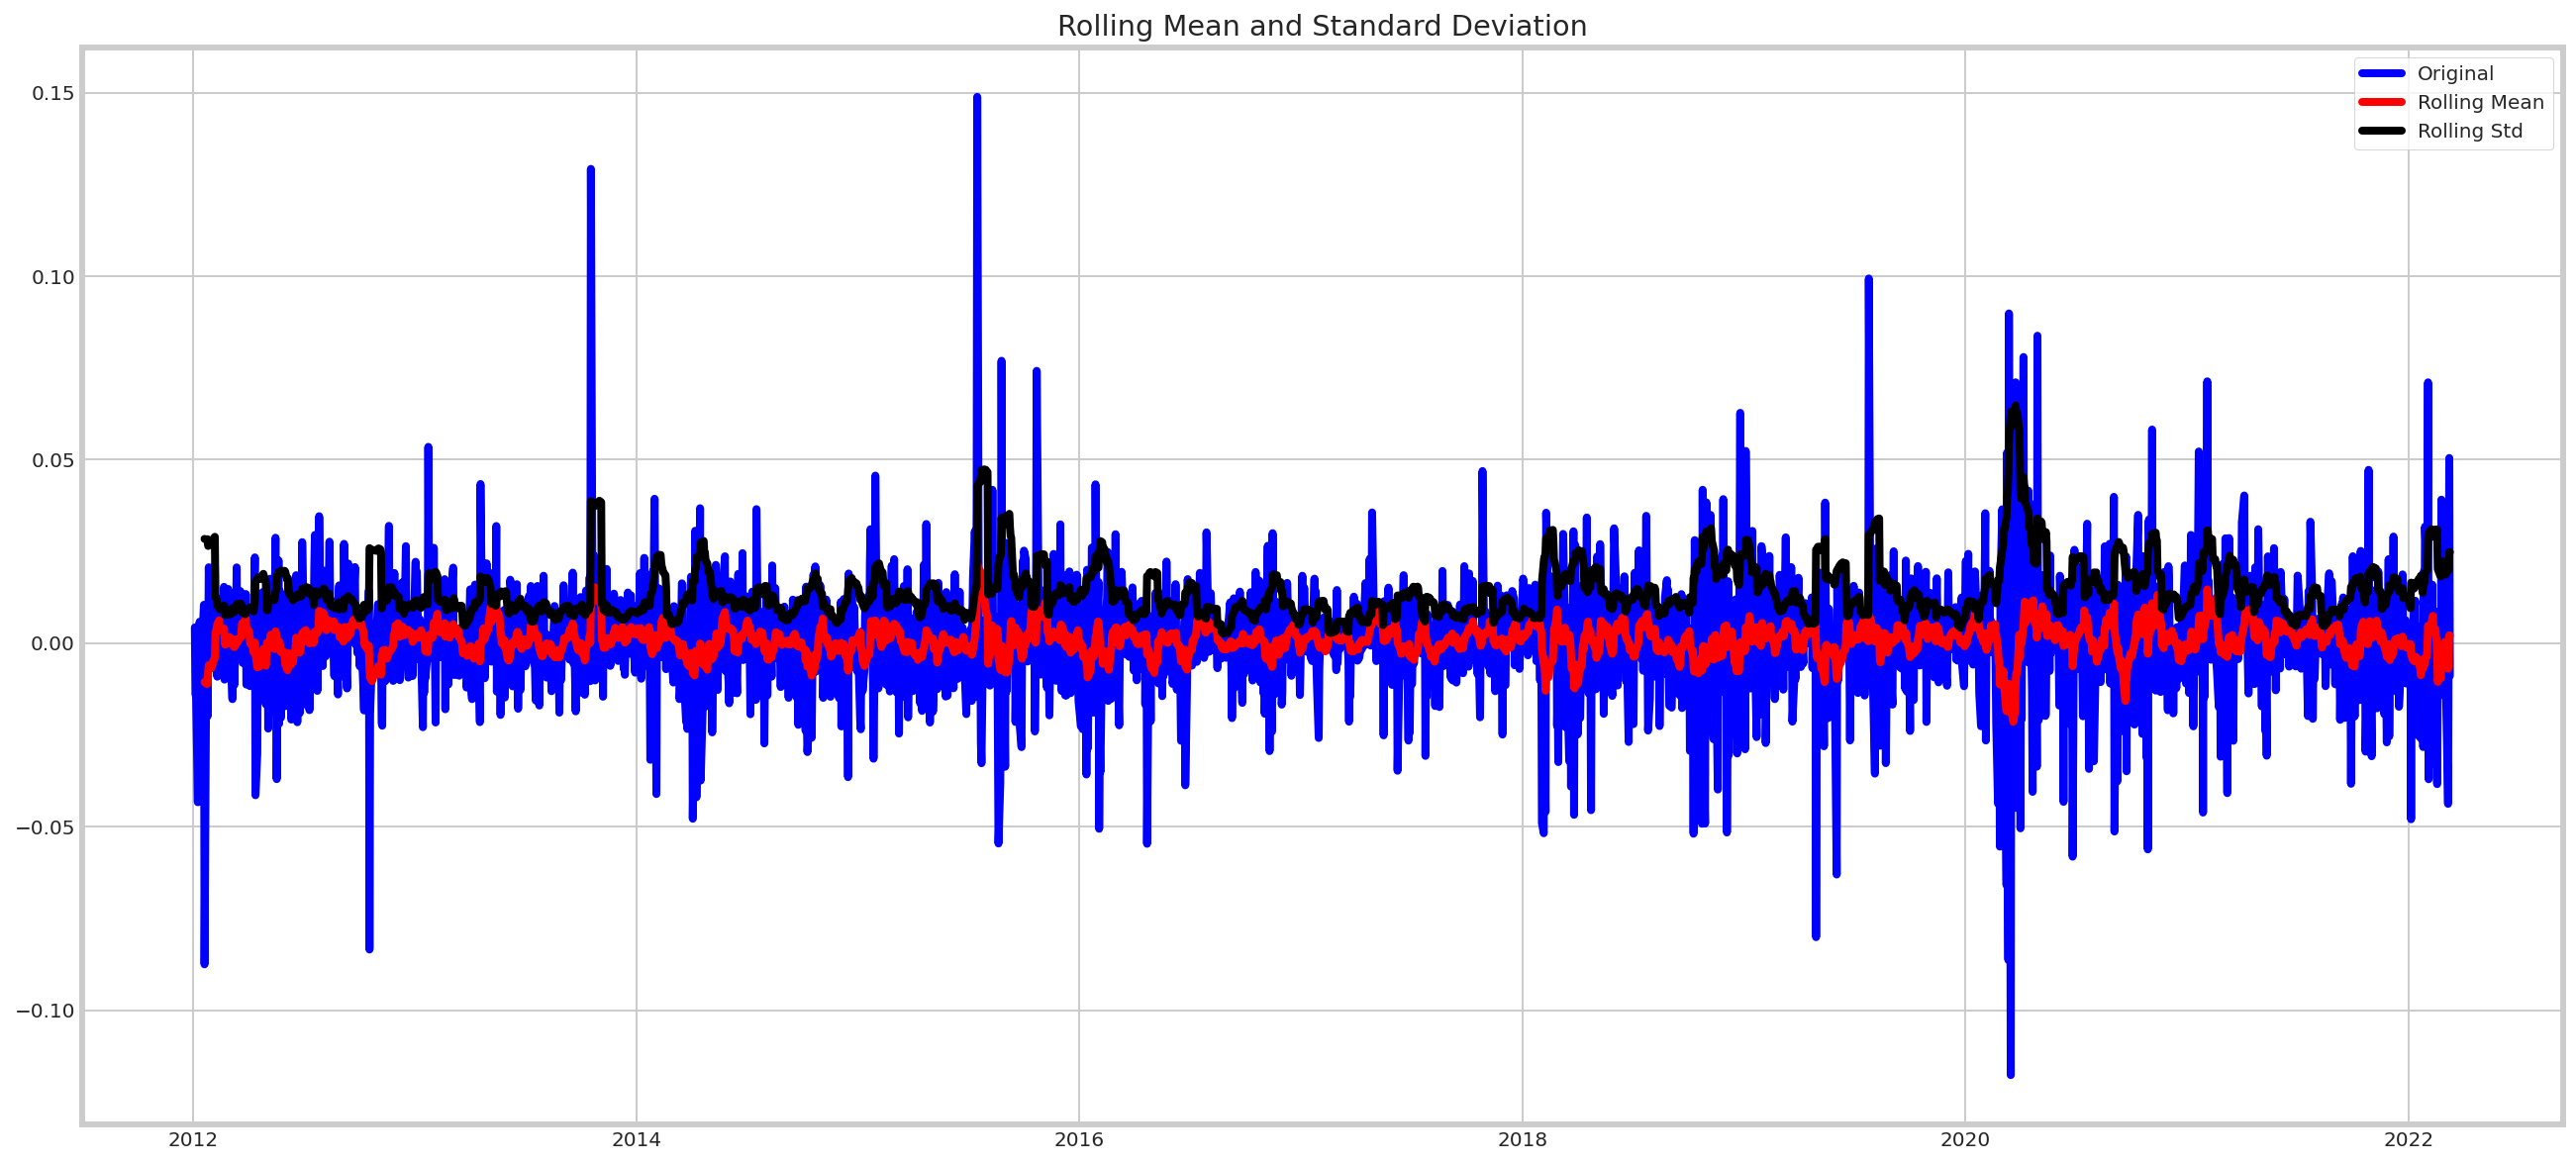

Results of dickey fuller test
Test Statistics               -1.147581e+01
p-value                        5.134479e-21
No. of lags used               1.700000e+01
Number of observations used    2.545000e+03
Critical value (1%)           -3.432922e+00
Critical value (5%)           -2.862676e+00
Critical value (10%)          -2.567375e+00
dtype: float64


In [125]:
df_log_shift = google_adj_close_log - google_adj_close_log.shift()  #Other technique to make time series Stationary
df_log_shift.dropna(inplace=True)
test_adf(df_log_shift)

In [127]:
google['Adj Close']=google_adj_close_log

In [128]:
google['Adj Close']

Date
2012-01-03    5.803515
2012-01-04    5.807819
2012-01-05    5.793850
2012-01-06    5.780115
2012-01-09    5.736791
                ...   
2022-03-04    7.879458
2022-03-07    7.835694
2022-03-08    7.842110
2022-03-09    7.892572
2022-03-10    7.883688
Name: Adj Close, Length: 2564, dtype: float64

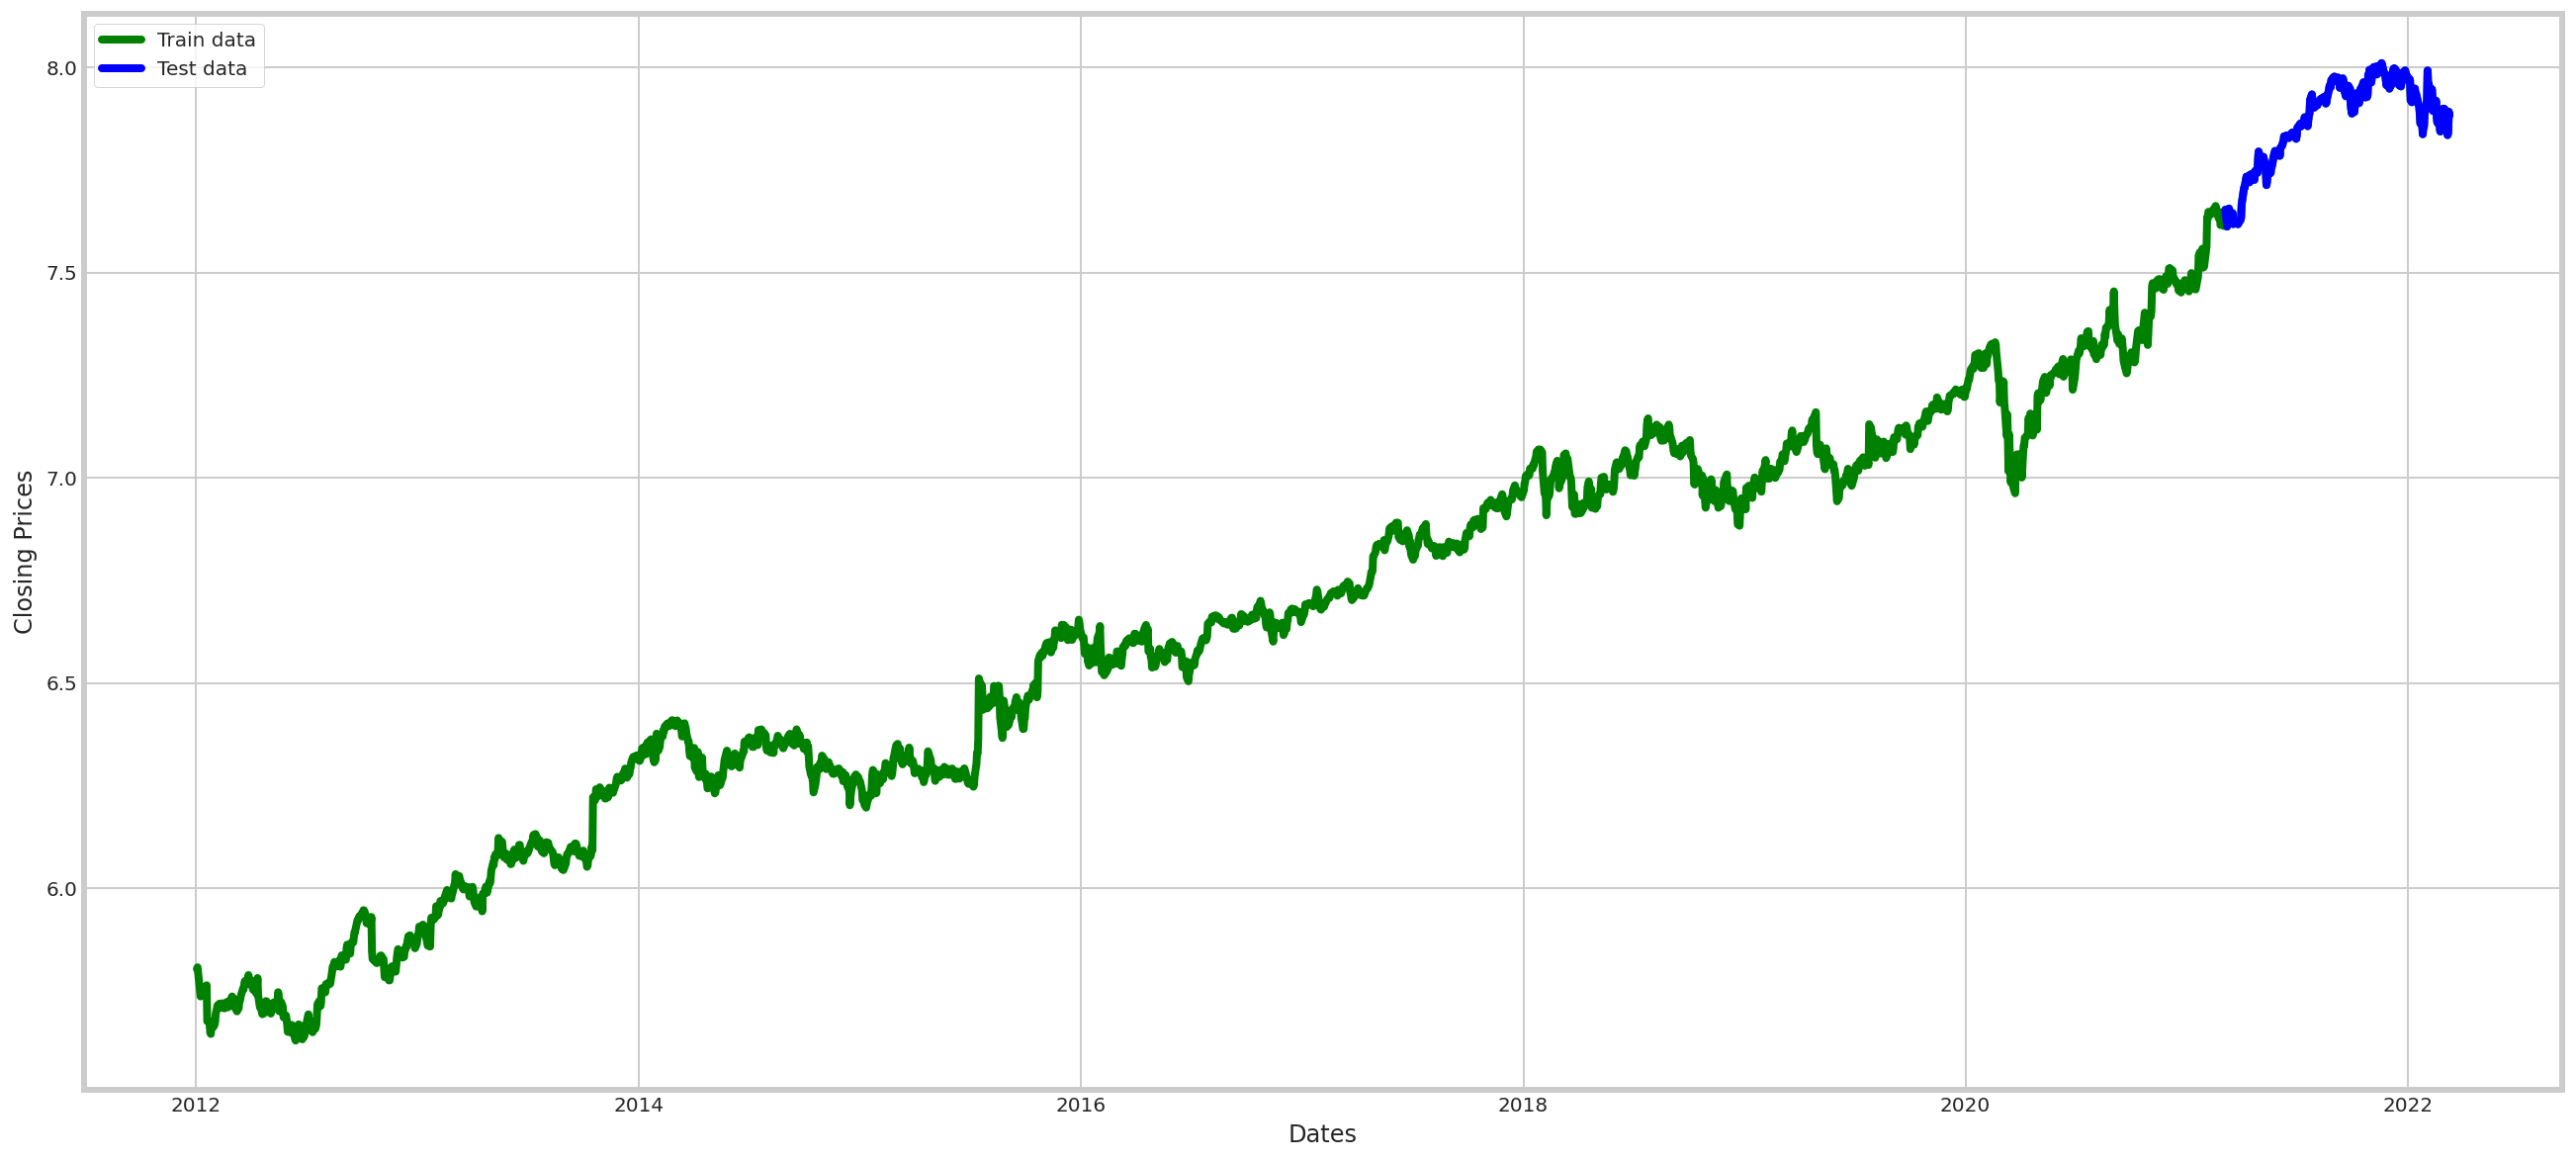

In [129]:
train_data,test_data=google_adj_close_log[:int(len(google_adj_close_log)*0.9)], google_adj_close_log[int(len(google_adj_close_log)*0.9):]
plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(google_adj_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [130]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=7, max_q=7, 
                      m=1,              
                      d=None,
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15280.361, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12511.513, Time=1.64 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12478.086, Time=1.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12507.187, Time=1.94 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.69 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=7.36 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12513.821, Time=1.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=198.273, Time=0.93 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12511.958, Time=1.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-12511.842, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3297.353,

In [131]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2307
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6260.911
Date:                Fri, 25 Mar 2022   AIC                         -12513.821
Time:                        17:53:49   BIC                         -12490.846
Sample:                             0   HQIC                        -12505.446
                               - 2307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.004      0.291      0.771      -0.007       0.009
ar.L1          0.9998      0.001   1606.699      0.000       0.999       1.001
ma.L1         -0.0589      0.013     -4.495      0.0

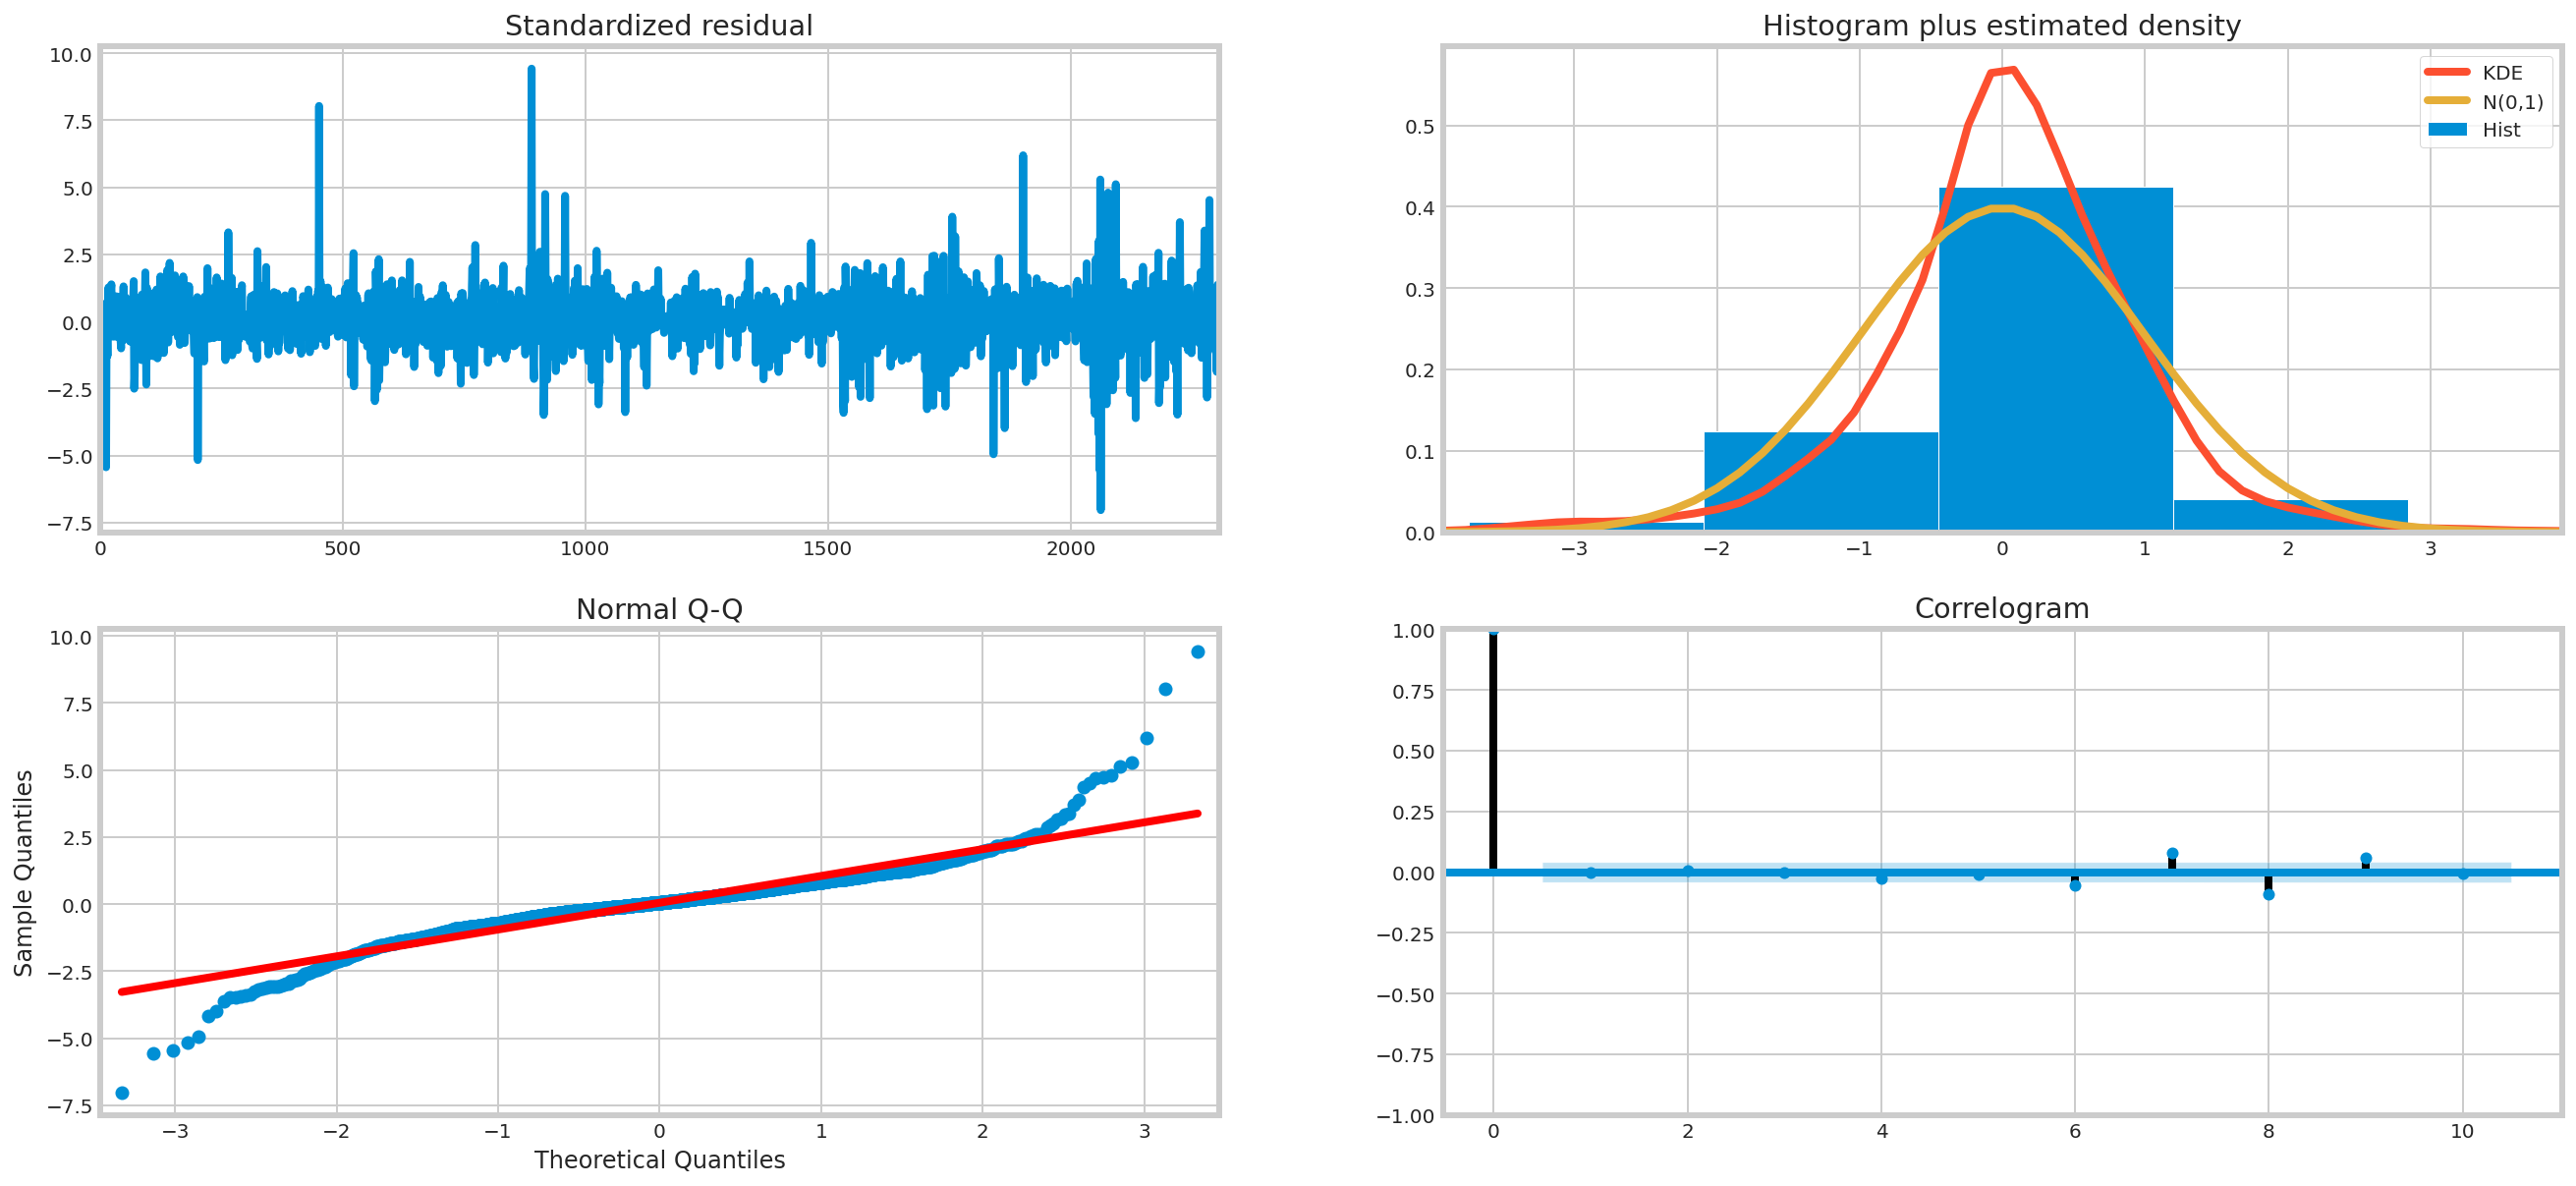

In [132]:
model_autoARIMA.plot_diagnostics(figsize=(20,10))
plt.show()

In [133]:
from statsmodels.tsa.arima_model import ARIMA
model = sm.tsa.arima.ARIMA(train_data, order=(1, 0, 1))  
fitted = model.fit() 
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2307
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6260.905
Date:                Fri, 25 Mar 2022   AIC                         -12513.810
Time:                        17:54:04   BIC                         -12490.835
Sample:                             0   HQIC                        -12505.435
                               - 2307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6166      0.788      8.396      0.000       5.072       8.161
ar.L1          0.9998      0.001   1591.072      0.000       0.999       1.001
ma.L1         -0.0594      0.013     -4.535      0.0

In [134]:
google_adj_close_log

Date
2012-01-03    5.803515
2012-01-04    5.807819
2012-01-05    5.793850
2012-01-06    5.780115
2012-01-09    5.736791
                ...   
2022-03-04    7.879458
2022-03-07    7.835694
2022-03-08    7.842110
2022-03-09    7.892572
2022-03-10    7.883688
Name: Adj Close, Length: 2564, dtype: float64

In [135]:
test_data.shape

(257,)

In [194]:
# Forecast
# Generate predictions
fc = fitted.forecast(123)
conf=fitted.get_forecast(123).conf_int(alpha=0.05)
se = fitted.bse



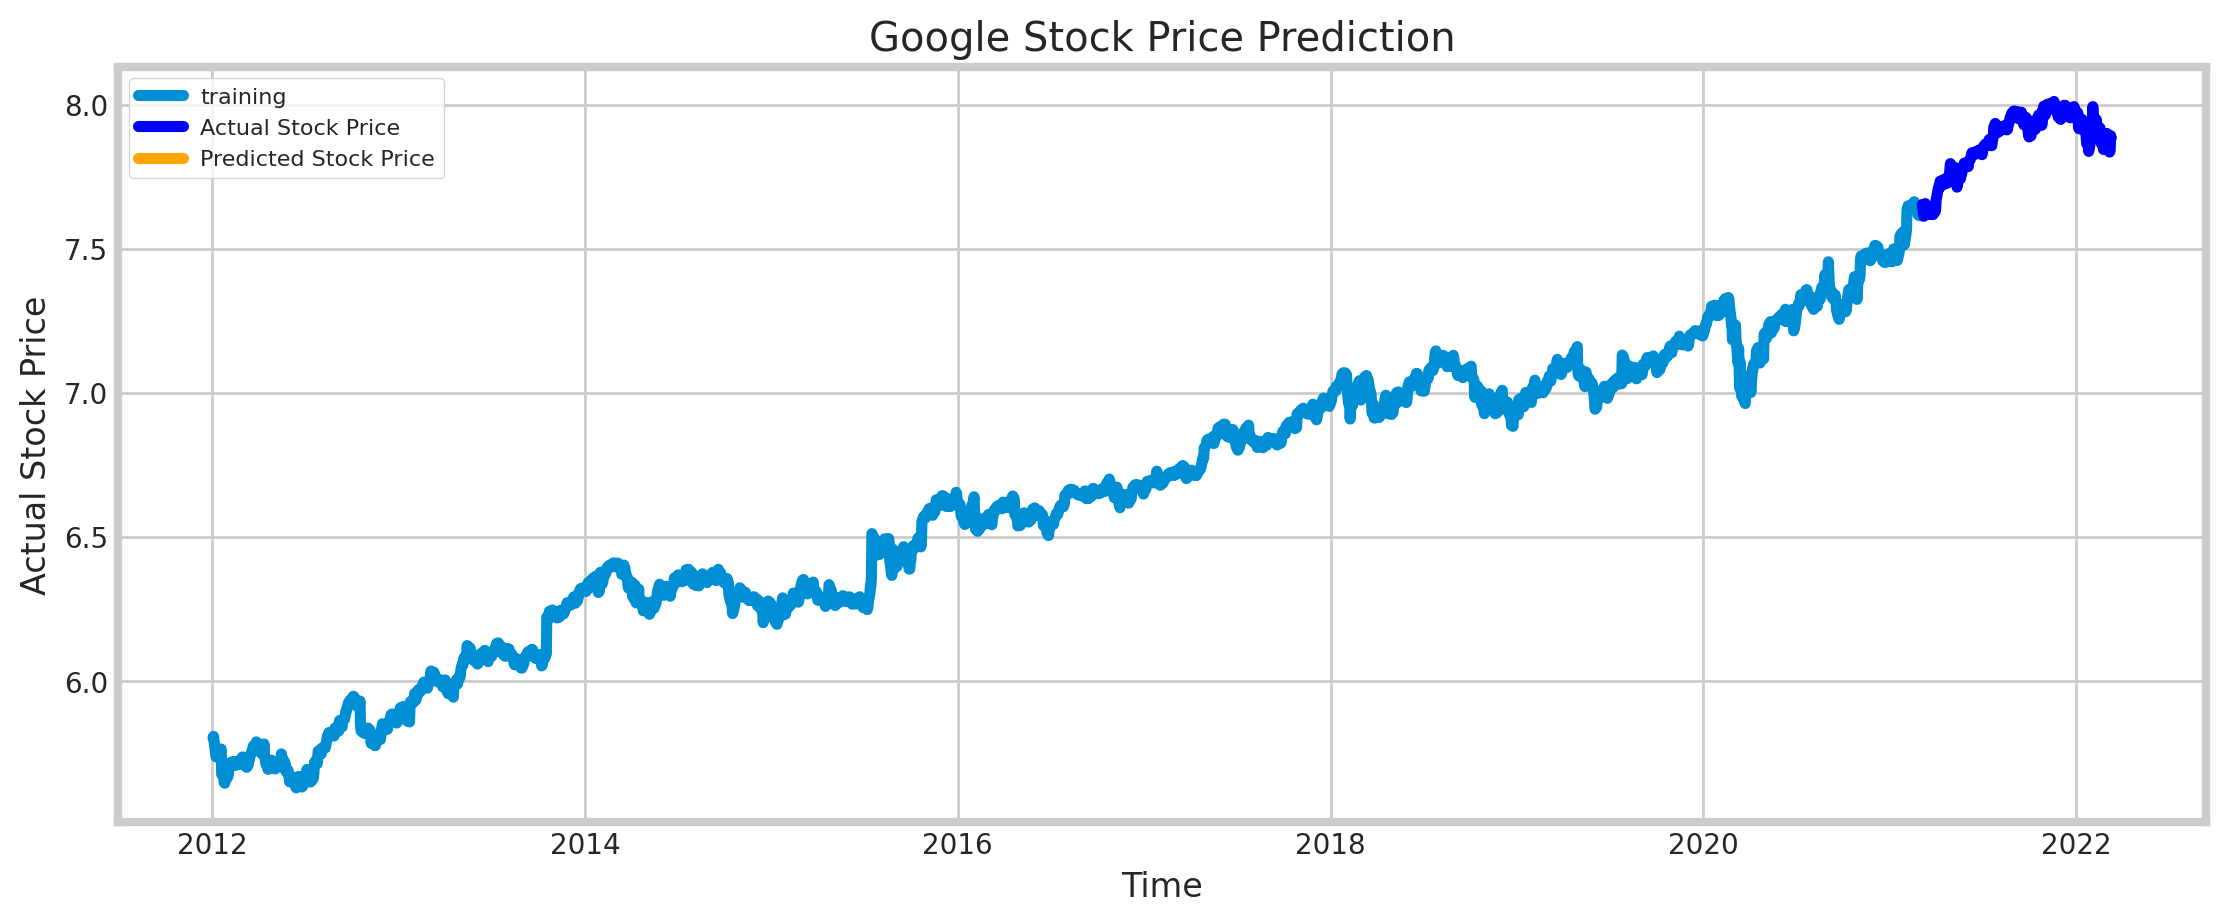

In [195]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:,0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:,1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [198]:
minmax = MinMaxScaler().fit(google.iloc[:, 4:5].astype('float32')) # Close index
google_log = minmax.transform(google.iloc[:, 4:5].astype('float32')) # Close index
google_log = pd.DataFrame(google_log)
google_log.head()

,0
0,0.295258
1,0.229936
2,0.263614
3,0.216181
4,0.467796


In [200]:
test_size = 30
simulation_size = 10

google_train = google_log.iloc[:-test_size]
google_test = google_log.iloc[-test_size:]
google.shape, google_train.shape, google_test.shape

((2564, 6), (2534, 1), (30, 1))

In [233]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
%tensorflow_version 1.x
sns.set()
tf.compat.v1.random.set_random_seed(1234)
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

TensorFlow is already loaded. Please restart the runtime to change versions.


In [234]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [235]:


def forecast():
  tf.reset_default_graph()
  modelnn = Model(
    learning_rate, num_layers, google_log.shape[1], size_layer, google_log.shape[1], dropout_rate
  )
  sess = tf.InteractiveSession()
  sess.run(tf.global_variables_initializer())
  date_ori = pd.to_datetime(google.iloc[:, 0]).tolist()

  pbar = tqdm(range(epoch), desc = 'train loop')
  for i in pbar:
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss, total_acc = [], []
    for k in range(0, google_train.shape[0] - 1, timestamp):
      index = min(k + timestamp, google_train.shape[0] - 1)
      batch_x = np.expand_dims(
        google_train.iloc[k : index, :].values, axis = 0
      )
      batch_y = google_train.iloc[k + 1 : index + 1, :].values
      logits, last_state, _, loss = sess.run(
        [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
        feed_dict = {
         modelnn.X: batch_x,
         modelnn.Y: batch_y,
         modelnn.hidden_layer: init_value,
        },
      )        
      init_value = last_state
      total_loss.append(loss)
      total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
  future_day = test_size

  output_predict = np.zeros((google_train.shape[0] + future_day, google_train.shape[1]))
  output_predict[0] = google_train.iloc[0]
  upper_b = (google_train.shape[0] // timestamp) * timestamp
  init_value = np.zeros((1, num_layers * 2 * size_layer))

  for k in range(0, (google_train.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
      [modelnn.logits, modelnn.last_state],
      feed_dict = {
        modelnn.X: np.expand_dims(
          google_train.iloc[k : k + timestamp], axis = 0
        ),
        modelnn.hidden_layer: init_value,
      },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

  if upper_b != google_train.shape[0]:
    out_logits, last_state = sess.run(
      [modelnn.logits, modelnn.last_state],
      feed_dict = {
        modelnn.X: np.expand_dims(google_train.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
      },
    )
    output_predict[upper_b + 1 : google_train.shape[0] + 1] = out_logits
    future_day -= 1
    date_ori.append(date_ori[-1] + timedelta(days = 1))

  init_value = last_state
    
  for i in range(future_day):
    o = output_predict[-future_day - timestamp + i:-future_day + i]
    out_logits, last_state = sess.run(
      [modelnn.logits, modelnn.last_state],
      feed_dict = {
        modelnn.X: np.expand_dims(o, axis = 0),
        modelnn.hidden_layer: init_value,
      },
    )
    init_value = last_state
    output_predict[-future_day + i] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))
    
  output_predict = minmax.inverse_transform(output_predict)
  deep_future = anchor(output_predict[:, 0], 0.3)
    
  return deep_future[-test_size:]

In [236]:
results = []
for i in range(simulation_size):
  print('simulation %d'%(i + 1))
  results.append(forecast())

simulation 1


AttributeError: ignored